## This project accomplished the visualization of results to gain confidence on the computed free energy and tools to judge the estimate☁️


Alchemical free energy calculations employ unphysical intermediate to estimate the free energies of various physical processes.

In [8]:
#alchemlyb is a library for doing alchemical free energy calculations more easily
#also import self defined package for pasing the amber output file in desired format
from alchemlyb_module.src.alchemlyb.parsing import amber
import alchemlyb
import warnings

In [2]:
#list all amber output file in the directory
import os
path='/Users/freyali/2023summerb/2023summer/alchemlyb/data/'
file_raw=os.listdir(path=path)

In [3]:
file_raw

['0.0479',
 '0.37',
 '0.1151',
 '.DS_Store',
 '0.6839',
 '1.0',
 '0.885',
 '0.5626',
 '0.25',
 '0.2063',
 '0.4374',
 '0.7937',
 '0.3161',
 '0.0',
 '0.9521',
 'alchemlyb_analysis']

In [7]:
#clean and sort the order
ordered_list=list(filter(lambda x: x[-1].isdigit(),file_raw))
ordered_list.sort()
ordered_list

['0.0',
 '0.0479',
 '0.1151',
 '0.2063',
 '0.25',
 '0.3161',
 '0.37',
 '0.4374',
 '0.5626',
 '0.6839',
 '0.7937',
 '0.885',
 '0.9521',
 '1.0']

In [19]:
#concat dHdl dataframes
warnings.filterwarnings("ignore")
dfs_dHdl=[]
for i in ordered_list:
     dfs_dHdl.append(amber.extract_dHdl(f'/Users/freyali/2023summerb/2023summer/alchemlyb/data/{i}/ti.out', 300))

df_dHdl=alchemlyb.concat(dfs_dHdl)        

df_dHdl.head()

,,dHdl
time,lambdas,
42.0,0.0,0.0
44.0,0.0,0.0
46.0,0.0,0.0
48.0,0.0,0.0
50.0,0.0,0.0


In [20]:
#concat u_nk  dataframes
#note: warning is normal that energies indeed larger than 0 kcal/mol
dfs_u_nk=[]
for i in ordered_list:
     dfs_u_nk.append(amber.extract_u_nk(f'/Users/freyali/2023summerb/2023summer/alchemlyb/data/{i}/ti.out', 300))

df_u_nk=alchemlyb.concat(dfs_u_nk)        
df_u_nk.head()

,,0.0000,0.0479,0.1151,0.2063,0.2500,0.3161,0.3700,0.4374,0.5626,0.6839,0.7937,0.8850,0.9521,1.0000
time,lambdas,,,,,,,,,,,,,,
42.0,0.0,0.0,0.241153,2.852695,11.722345,17.235594,26.166983,34.110436,46.140469,85.500052,185.720684,479.103343,1199.810018,1741.373945,1808.883845
44.0,0.0,0.0,0.251606,3.020050,13.153374,20.225914,33.549656,47.839296,73.688063,178.863480,524.083941,1832.318245,5261.101579,7773.930120,8083.779363
46.0,0.0,0.0,0.263451,3.141153,13.310898,20.026113,31.743397,43.047648,60.992034,115.717984,212.464380,332.813374,413.759703,437.216820,439.373015
48.0,0.0,0.0,0.242107,2.881712,12.103851,18.074352,28.268755,37.966881,53.544147,105.455670,220.889083,436.198419,663.584209,749.074200,757.483101
50.0,0.0,0.0,0.294278,3.550013,15.813286,24.791392,42.847823,63.816592,104.894189,293.158215,988.061476,3983.975176,18062.485916,59272.432720,72546.096970


## Visualization

##### Overlap Matrix of the MBAR

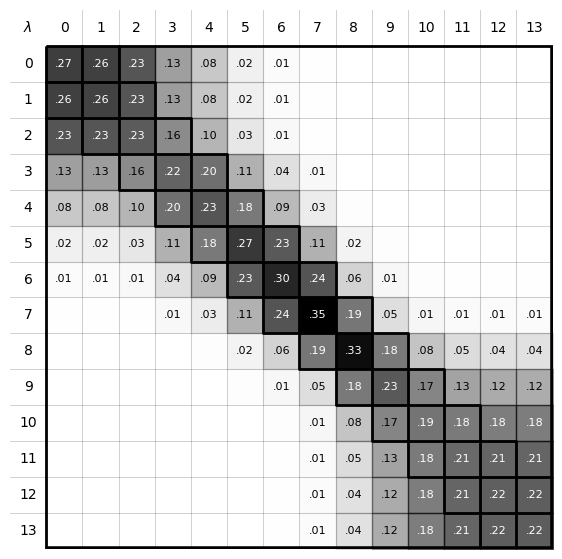

In [13]:
from alchemlyb.estimators import MBAR
mbar_coul = MBAR()
mbar_coul.fit(df_u_nk)
from alchemlyb.visualisation import plot_mbar_overlap_matrix

ax = plot_mbar_overlap_matrix(mbar_coul.overlap_matrix)

Check the degree of overlap, all the **neighboring** lambda states is over 0.03 so the accuracy of the MBAR estimator can be ensured. 

#### dhdl Plot of the TI

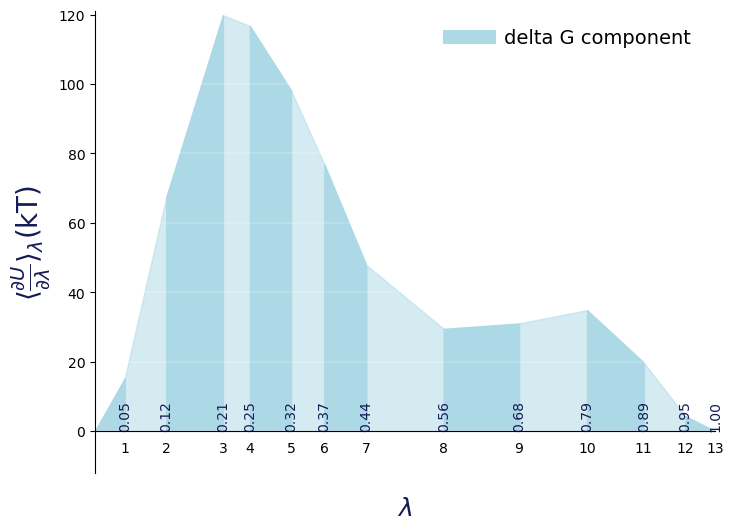

In [14]:
from alchemlyb.estimators import TI

ti = TI().fit(df_dHdl)

from alchemlyb.visualisation import plot_ti_dhdl
ax = plot_ti_dhdl([ti], labels=['delta G component '], colors=['lightblue'])

#### dF States Plots between Different estimators

In [15]:
from alchemlyb.estimators import MBAR, TI, BAR
import matplotlib.pyplot as plt
import pandas as pd
from alchemlyb.visualisation.dF_state import plot_dF_state

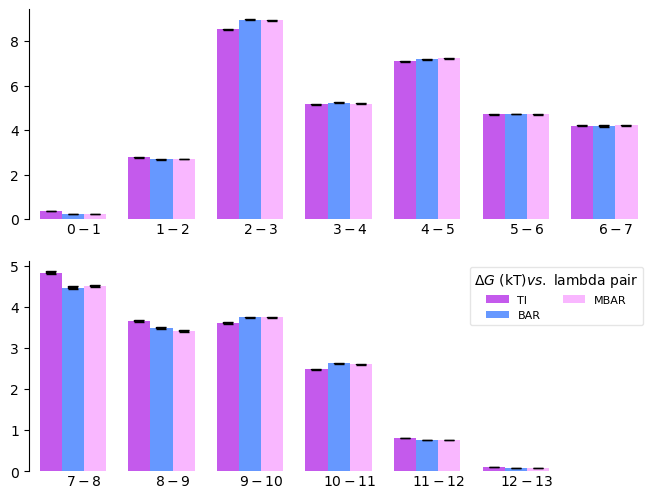

In [17]:
from alchemtest.gmx import load_benzene
from alchemlyb.parsing.gmx import extract_u_nk, extract_dHdl
from alchemlyb.estimators import MBAR, TI, BAR
import matplotlib.pyplot as plt
import pandas as pd
from alchemlyb.visualisation.dF_state import plot_dF_state

ti = TI().fit(df_dHdl)

bar = BAR().fit(df_u_nk)

mbar = MBAR().fit(df_u_nk)

estimators = [ti,bar,mbar]

fig = plot_dF_state(estimators, orientation='portrait')


The intermediate state of lambda does not have physical meaning. However, the big difference from different estimation methods is an good indicator that more simulation is needed.

### Forward and Backward Convergence

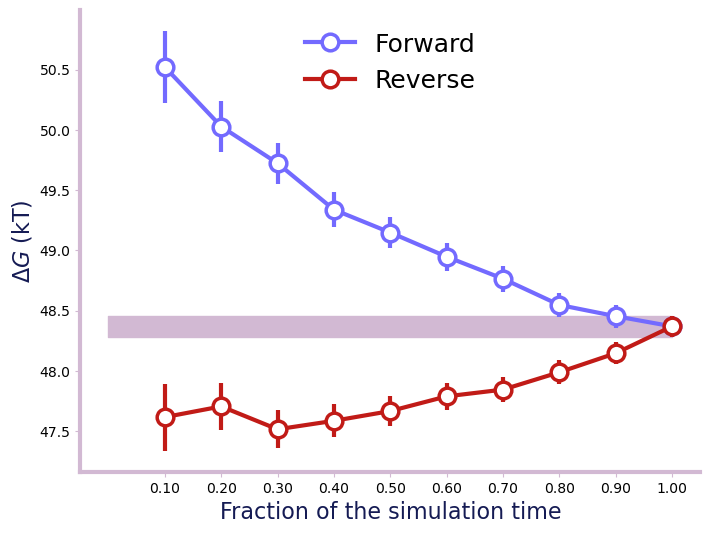

In [18]:
import pandas as pd
from alchemtest.gmx import load_benzene
from alchemlyb.parsing.gmx import extract_u_nk
from alchemlyb.estimators import MBAR
dfs_u_nk

forward = []
forward_error = []
backward = []
backward_error = []
num_points = 10
for i in range(1, num_points+1):
    # Do the forward
    slice = int(len(dfs_u_nk[0])/num_points*i)
    u_nk = alchemlyb.concat([data[:slice] for data in dfs_u_nk])
    estimate = MBAR().fit(u_nk)
    forward.append(estimate.delta_f_.iloc[0,-1])
    forward_error.append(estimate.d_delta_f_.iloc[0,-1])
    # Do the backward
    u_nk = alchemlyb.concat([data[-slice:] for data in dfs_u_nk])
    estimate = MBAR().fit(u_nk)
    backward.append(estimate.delta_f_.iloc[0,-1])
    backward_error.append(estimate.d_delta_f_.iloc[0,-1])


from alchemlyb.visualisation import plot_convergence
ax = plot_convergence(forward, forward_error, backward, backward_error)

Evaluation of forward and backward free energy differences provides an indication of convergence. For this graph, at 50% of the simulation time, there is still a 1.5 gap in Gibbs free energy so the convergency might not meet the requirement. Changing the amount of time of simulation could improve the convergency while the increased computational costs also need to be considered. 

Furthermore, the potential energy differences generated from both directions can be utilized to reduce statistical error. 